# Fine-tuning PaliGemma using Adapters

Adapters are small neural network components that are inserted into a (usually) transformer model with mostly frozen weights to fine-tune a pre-traiend model without having to update the entire set of parameters, thus saving computational resources. Here we will be fine-tuning a pretrained pali-gemma model with bottleneck adapters inserted into the language model section of paligemma. See the full report for details.

In [1]:
#!git clone https://github.com/adapter-hub/adapters.git
#%cd adapters
#!pip install .
#!pip install -U bitsandbytes
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DI725/DI725-project


Mounted at /content/drive
/content/drive/MyDrive/DI725/DI725-project


In [ ]:
import adapters
from adapters import AdapterModelInterface

In [3]:
import torch
from torch import nn

from transformers import BitsAndBytesConfig
from transformers import AutoProcessor, AutoModel, PaliGemmaForConditionalGeneration, AutoConfig

from huggingface_hub import notebook_login

from datasets import load_dataset

import wandb
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-pt-224" # pt for pre-trained, needs fine-tuning

In [ ]:
#process the dataset into jsonl files from the given captions csv

#!python3 process_dataset.py

## Load the dataset

In [5]:
dataset = load_dataset("json", data_files={'train': 'RISCM/resized/train_data.jsonl', 'test':'RISCM/resized/test_data.jsonl', 'validation':"RISCM/resized/val_data.jsonl"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
#We need to log-in before using the PaliGemma model, as it is subject to agreement

notebook_login()

## Load the model

In [ ]:
base_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Since PaliGemma in its currrent form isn't compatible with the adapters library, we need to make some small changes. We will add a custom identity head class that just outputs the language head as is. We use the custom model_addons module.

In [ ]:
import model_addons
from model_addons import IdentityHead, dummy_save_all_heads

# Add our custom identity head
base_model.heads = nn.ModuleDict({"identity_head": IdentityHead()})
base_model.save_all_heads = dummy_save_all_heads.__get__(base_model)


## Adding VL-adapter

PaliGemma model is not officially supported by the adapters library. We need to create a model interface object to be able to use it with adapters.

In [ ]:
bottleneck_interface_lm = AdapterModelInterface(
    adapter_methods=["bottleneck"], # the vanilla Adapter a.k.a bottleneck adapter
    model_embeddings="language_model.model.embed_tokens",
    model_layers="language_model.model.layers",
    layer_self_attn="self_attn",
    layer_cross_attn=None,
    attn_k_proj="k_proj",
    attn_q_proj="q_proj",
    attn_v_proj="v_proj",
    attn_o_proj="o_proj",
    layer_intermediate_proj="mlp.up_proj",
    layer_output_proj="mlp.down_proj",
)

In [ ]:
adapters.init(base_model, interface=bottleneck_interface_lm)
base_model.add_adapter("adapter_lm", config="double_seq_bn")
base_model.set_active_adapters("adapter_lm")
print(base_model.adapter_summary())

#moving to device
base_model.to(device)
base_model.adapter_to("adapter_lm", device=device)

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
adapter_lm               bottleneck       18,952,704       0.648       1       1
--------------------------------------------------------------------------------
Full model                              2,923,466,480     100.000               1


## Prepare for training

In [14]:
image_dir = "RISCM/resized/"
from PIL import Image
import PIL
def collate_fn(examples):
      texts = [f"<image> <bos> {example['prefix']}" for example in examples]
      labels= [example['suffix'] for example in examples]
      images = [PIL.Image.open(image_dir + example["file_name"]).convert("RGB") for example in examples]
      tokens = processor(text=texts, images=images, suffix=labels,
      return_tensors="pt", padding="longest")
      tokens = tokens.to(torch.bfloat16).to(device)
      return tokens

## Fine-tuning

In [ ]:
wandb.init(
    project="paligemma-finetune",
    name="run_visionadapter_batch4",
    config={
        "num_train_epochs": 2,
        "per_device_train_batch_size": 4,
        "gradient_accumulation_steps": 1,
        "learning_rate": 5e-4,
        "weight_decay": 1e-6,
        "adam_beta2": 0.999,
        "optim": "adamw_hf",
        "bf16": True,

    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yildizz-nisan (yildizz-nisan-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback
args=TrainingArguments(
            num_train_epochs=1,
            remove_unused_columns=False,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=1,
            warmup_steps=2,
            learning_rate=5e-4,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="paged_adamw_8bit", # you can use paged optimizers like paged_adamw_8bit for Q or adamw_hf
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=1,
            output_dir="paligemma_visionadapter",
            bf16=True,
            report_to=["wandb"],
            dataloader_pin_memory=False,
            evaluation_strategy="steps",
            eval_steps=1000,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
        )


In [ ]:
from adapters import AdapterTrainer

In [ ]:
base_model.active_head = "identity_head"
base_model._active_heads = [base_model.active_head]
base_model.train_adapter("adapter_lm")

In [ ]:
trainer = AdapterTrainer(
    model=base_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    data_collator=collate_fn,
    args=args
)
train_start = time.time()
trainer.train()
train_time = time.time() - train_start
print(f"Training time: {train_time:.2f} seconds")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
1000,1.418300,1.629701
2000,1.177600,1.444912
3000,1.057800,1.349869
4000,1.027400,1.257392
5000,0.951700,1.200210
6000,0.894300,1.161937
7000,0.848800,1.109456
8000,0.762300,1.072431


Training time: 33497.76 seconds


## Inference

In [6]:
def generate_caption(model, processor, input_text, input_image):
    inputs = processor(text=input_text,
                       images=input_image,
                       padding="longest",
                       do_convert_rgb=True,
                       return_tensors="pt").to(device)

    input_ids = inputs["input_ids"].to(device)
    pixel_values = inputs["pixel_values"].to(device)
    input_len = input_ids.shape[1]
    generated = input_ids.clone()
    max_new_tokens = 32

    with torch.no_grad():
        past_key_values = None
        for _ in range(max_new_tokens):
            model_inputs = {"input_ids": generated}
            if past_key_values is not None:
                model_inputs["past_key_values"] = past_key_values
            if generated.shape[1] == input_len:  # Only pass pixel_values on first step
                model_inputs["pixel_values"] = pixel_values
            out = model(**model_inputs)
            next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            past_key_values = out.past_key_values
            if next_token.item() == processor.tokenizer.eos_token_id:
                break
        # Decode generated tokens (skip input prompt)
        caption_ids = generated[0, input_len:]
        caption = processor.decode(caption_ids, skip_special_tokens=True)
        return caption.strip()


In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-cq377_f5
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-cq377_f5
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=62b5e159d8f3bb6d41b58374d38dd7bf767ee9da733a95c49771fdbd20ac9a2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-09yrxyja/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm

In [ ]:
gts = {}  # ground truths
res = {}  # results

image_dir = "RISCM/resized/"

base_model.eval()

eval_start = time.time()
for idx, example in tqdm(enumerate(dataset['test']), "inference on test test"):
    input_image = PIL.Image.open(image_dir + example["file_name"])
    references = [example['suffix']]  # list of reference captions
    input_text = f"<image> <bos> {example['prefix']}"

    pred_caption = generate_caption(model = base_model,
                                    processor = processor,
                                    input_text = input_text,
                                    input_image = input_image)
    gts[idx] = references
    res[idx] = [pred_caption]

eval_time = time.time() - eval_start
print(f"Evaluation time: {eval_time:.2f} seconds")

# Calculate CIDEr
cider_scorer = Cider()
score, scores = cider_scorer.compute_score(gts, res)
print(f"CIDEr score: {score:.4f}")

inference on test test: 4454it [1:39:46,  1.34s/it]


Evaluation time: 5986.86 seconds
CIDEr score: 1.4336


In [ ]:
res

{0: ['A plane is on the runway .'],
 1: ['Four planes are parked on the open space .'],
 2: ['A plane is parked on the open space .'],
 3: ['There are two planes in the parking lot .'],
 4: ['Two planes are parked on the open space .'],
 5: ['Four planes are parked on the open space .'],
 6: ['Three planes are parked on the open space .'],
 7: ['Two planes are parked on the open space .'],
 8: ['Two planes are parked on the open space .'],
 9: ['A plane is parked on the open space .'],
 10: ['Four planes are parked on the open space .'],
 11: ['Two planes are parked on the open space .'],
 12: ['Two planes are parked on the open space .'],
 13: ['Two planes are parked on the open space .'],
 14: ['Three planes are parked on the open space .'],
 15: ['Five planes are parked on the open space .'],
 16: ['Two planes are parked on the open space .'],
 17: ['Two blue planes are parked on the open space .'],
 18: ['Three planes are parked on the open space .'],
 19: ['Four planes are parked 

In [ ]:
gts

{0: ['There is an airplane on the runway with a large lawn by the runway .'],
 1: ['Four planes are parked on the runway .'],
 2: ['There is 1 plane on the ground marked .'],
 3: ['A large plane and a small plane are parked near the terminal .'],
 4: ['Two planes are parked next to the terminal .'],
 5: ['Many planes are parked around the terminal .'],
 6: ['Three planes parked beside buildings inside the airport, Many cars parked next to the plane .'],
 7: ['Two planes are parked on the runway .'],
 8: ['Two planes are on the marked ground .'],
 9: ['There is a white plane in the open space, Surrounded by two white cars and three orange cars .'],
 10: ['Four planes parked at three airports .'],
 11: ['There are two planes of the same size on a clearing, With a large lawn next to the clearing .'],
 12: ['Two white planes stopped at the yellow line .'],
 13: ['A small plane and a big plane parked next to boarding bridges while some white facilities around them .'],
 14: ['The three airp

In [ ]:
base_model.save_adapter(save_directory="paligemma_visionadapter/final", adapter_name="adapter_lm")

In [ ]:
with open('visionadapter_captions.txt', 'w') as f:
    print(res, file=f)
f.close()

In [ ]:
with open('visionadapter_gts.txt', 'w') as f:
    print(gts, file=f)
f.close()

## Example captions

In [9]:
import ast

with open('visionadapter_captions.txt', 'r') as f:
    content = f.read()
    preds = ast.literal_eval(content)
    f.close()

with open('visionadapter_gts.txt', 'r') as f:
    content = f.read()
    gts = ast.literal_eval(content)
    f.close()


In [11]:
example_ids = [42, 132, 1024, 2062, 4000]
example_gt = []
example_pred = []

for example_id in example_ids:
    example_gt.append(gts[example_id])
    example_pred.append(preds[example_id])

### Predicted captions

In [12]:
!mkdir example_captions/vision_adapter

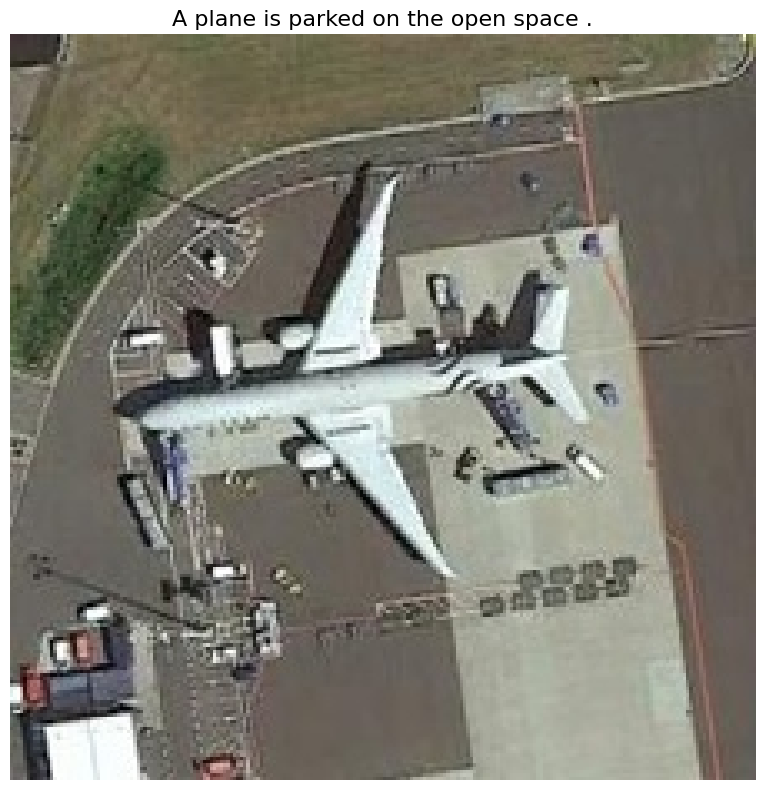

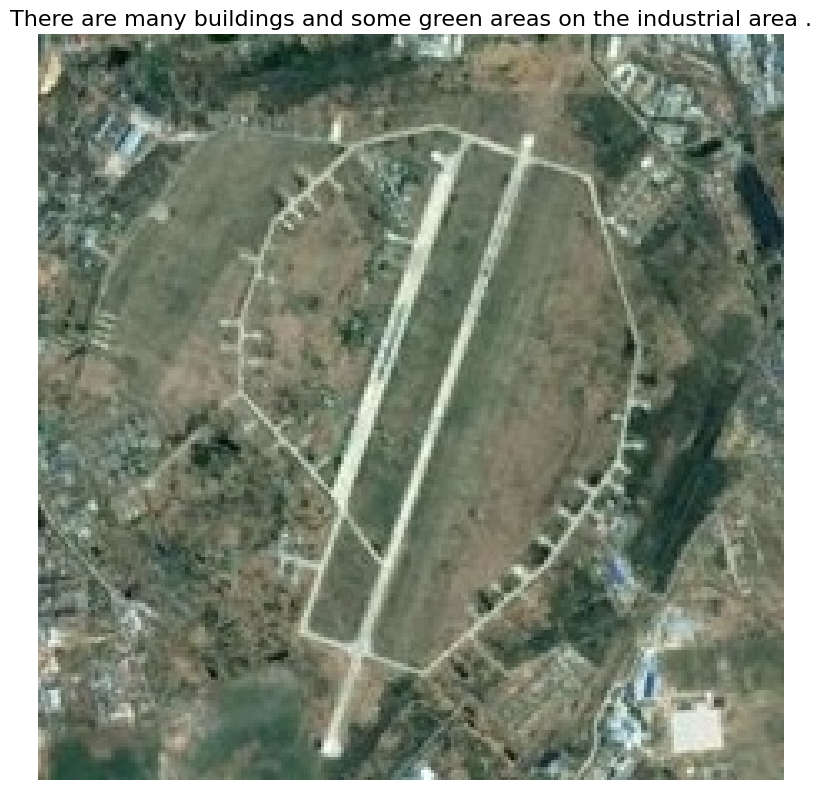

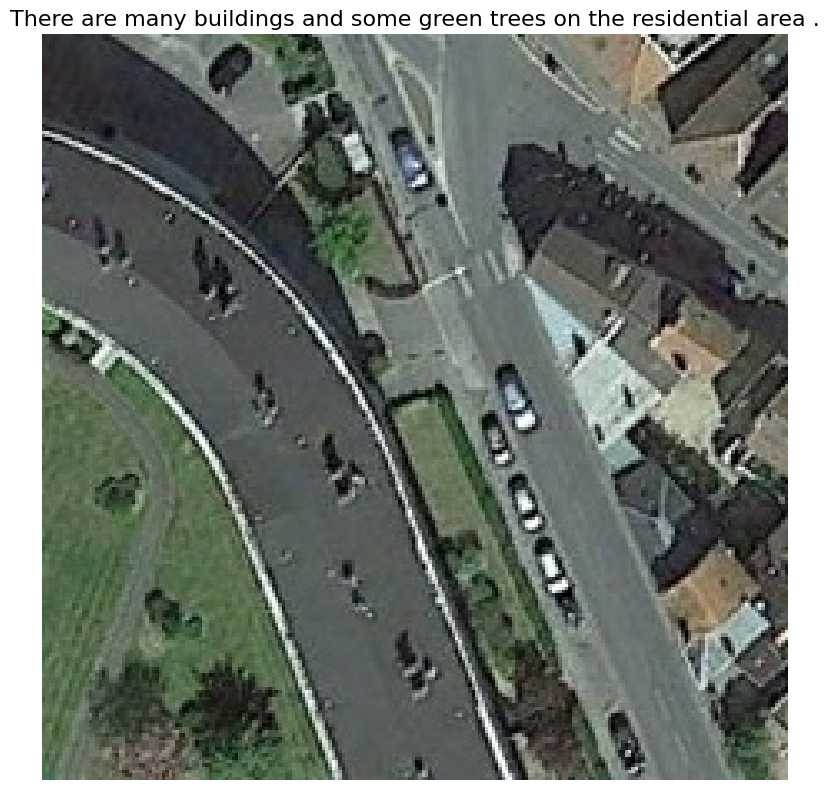

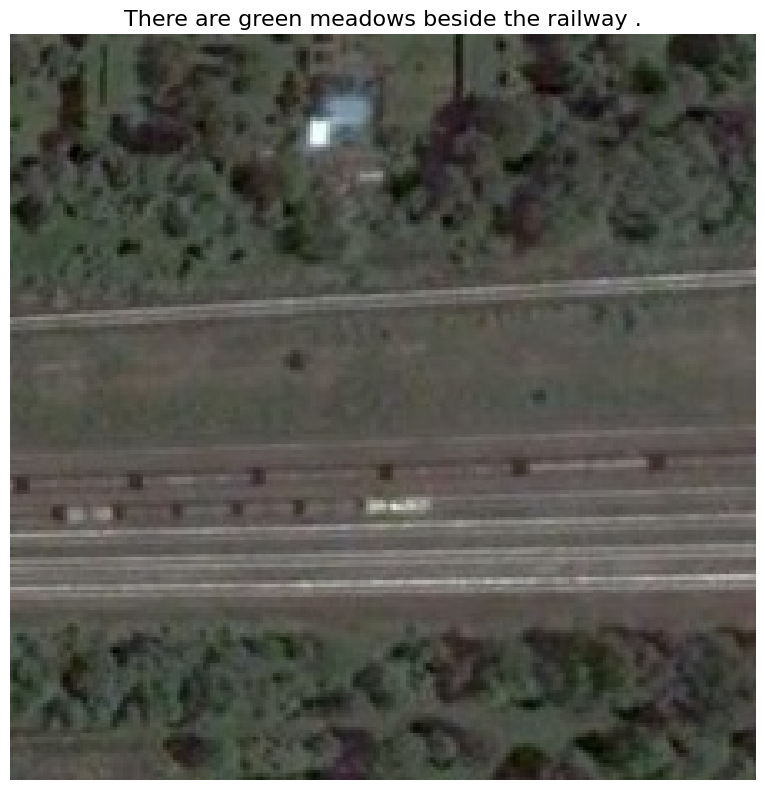

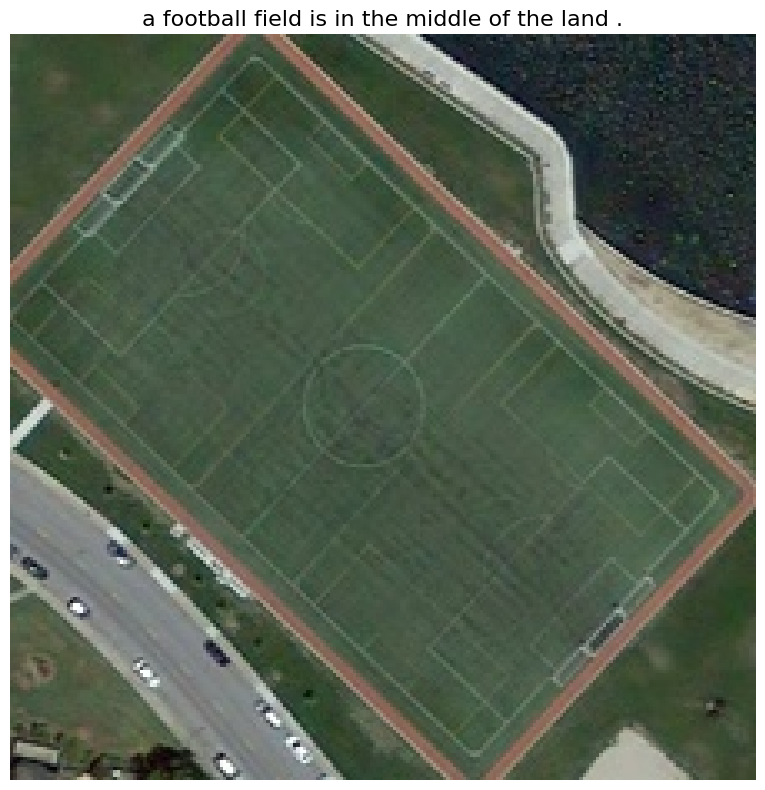

In [15]:
import matplotlib.pyplot as plt
for i in range(len(example_ids)):
    img = PIL.Image.open(image_dir + dataset['test'][example_ids[i]]["file_name"])
    caption = example_pred[i][0]
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"example_captions/vision_adapter/test_{example_ids[i]}.png")
    plt.show()

### Ground truth captions

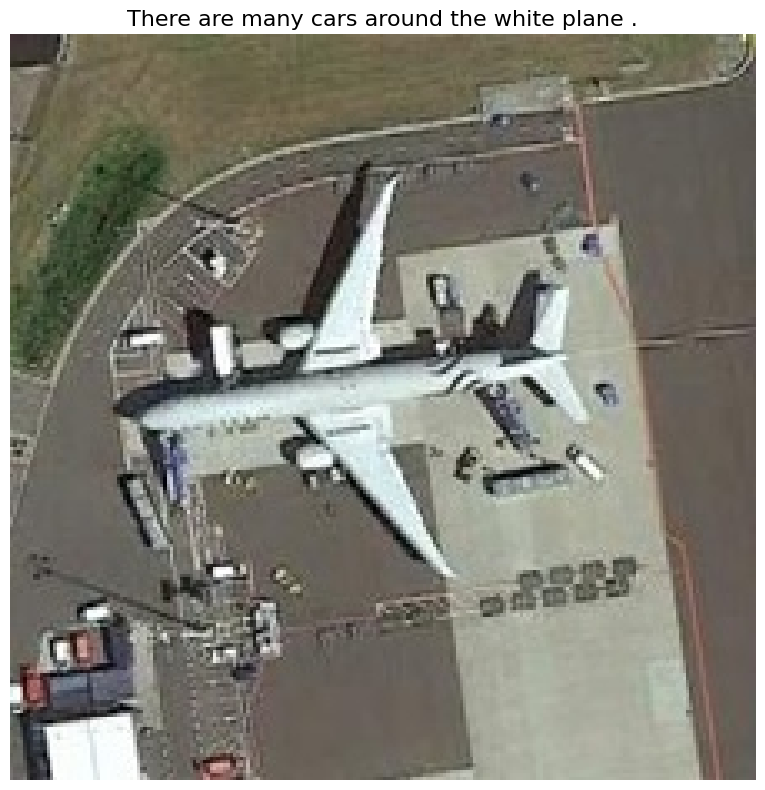

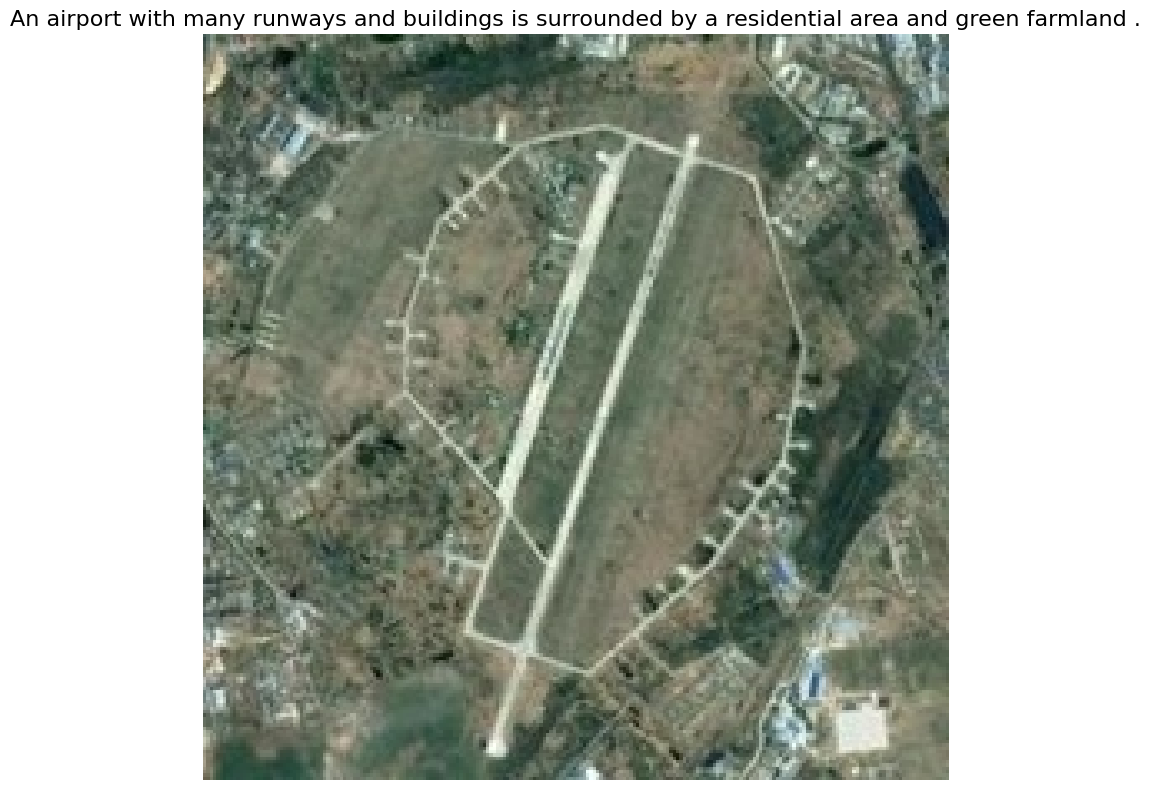

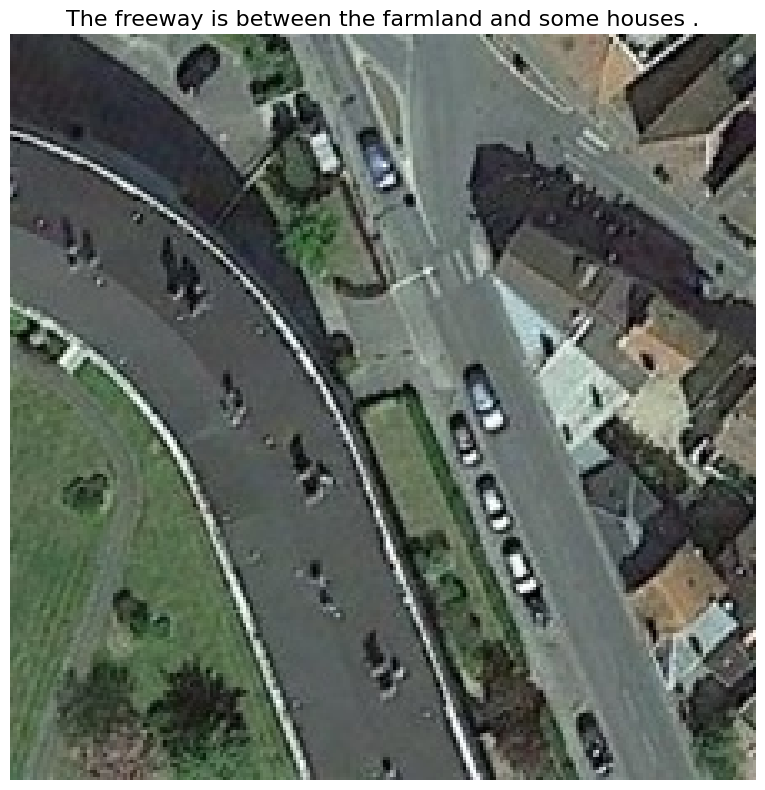

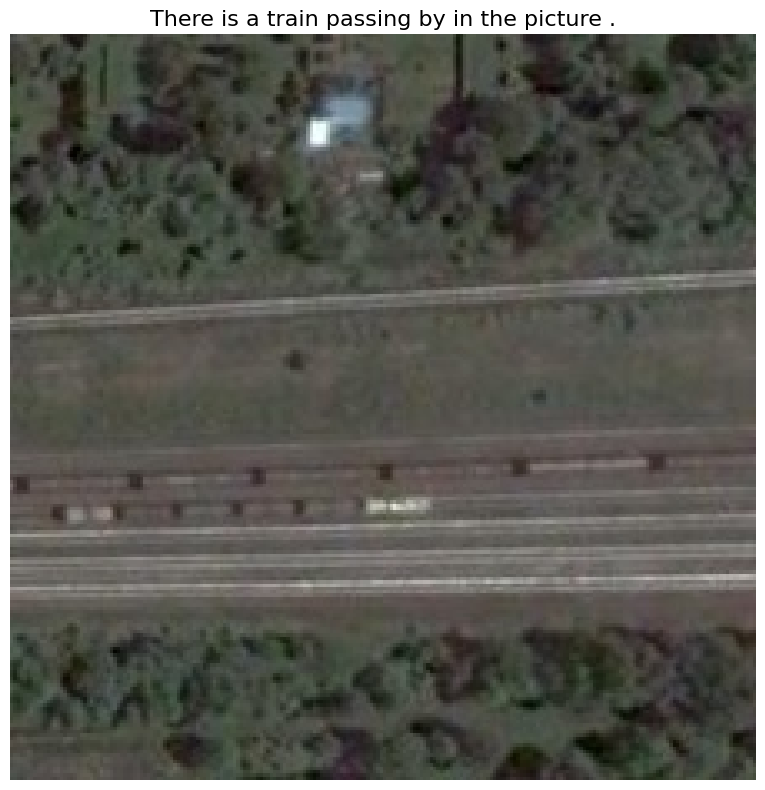

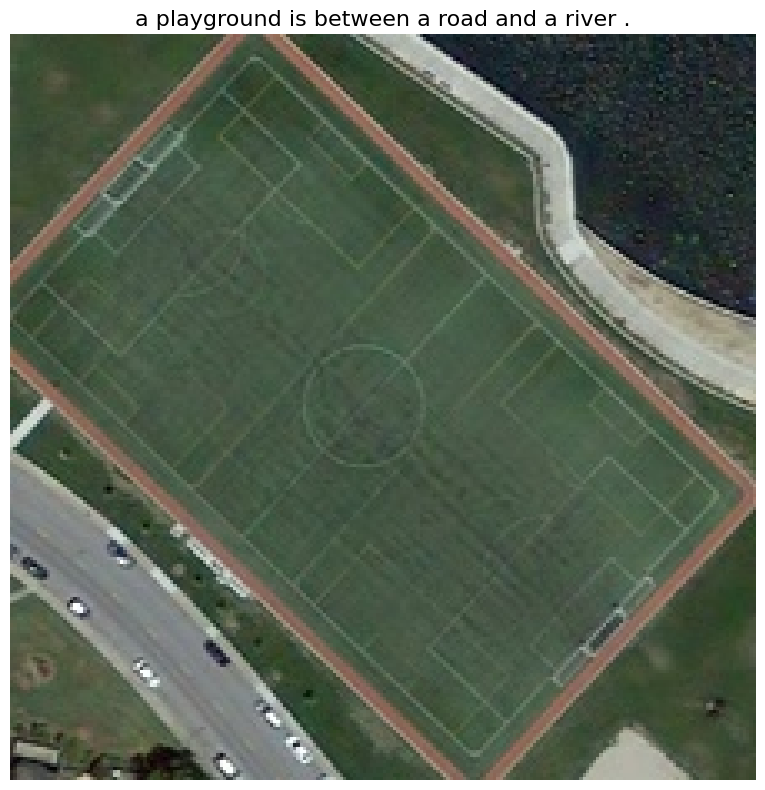

In [16]:
import matplotlib.pyplot as plt
for i in range(len(example_ids)):
    img = PIL.Image.open(image_dir + dataset['test'][example_ids[i]]["file_name"])
    caption = example_gt[i][0]
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.tight_layout()
    plt.show()

